# Trabalho Visão Computacional - Ep 3 - Parte 1

- Diego Pavan Soler NUSP: 4607661
- José Luiz Maciel Pimenta NUSP: 11896720
- Luis Ricardo Manrique NUSP: 5779294

# 1. Introdução

## Compartilhamento do Projeto
- Git: https://github.com/JoseLuiz432/MAC5768.git
- Drive: https://drive.google.com/drive/folders/1bvwXFjPWP-Sdb5Lwh6zFd_vQs24mJ6_c?usp=sharing

# 2 - Objetivos

Este trabalho tem dois objetivos principais.

O primeiro objeto é a segmentação do objeto de interesse, onde será objeto será separado do fundo, produzindo uma imagem binária: 0 para o fundo e 1 para o objeto. Nesta seção, dois tipos de segmentação serão usados: manual, para geração do ground-truth, para pelo menos 15% de cada classe do dataset, e automática, onde vários algoritmos serão testados para chegar a um resultado mais perto possível da segmentação manual. Depois, será calculado a Bounding Box da imagem segmentada.

O segundo objetivo é a classificação do objeto de interesse, onde será calculado as um vetor de features para a região definida pelo Bounding Box e com este vetor, será possível prever a qual classe um objeto em uma imagem pertence.

A seguir estão apresentados os pipelines das duas partes:


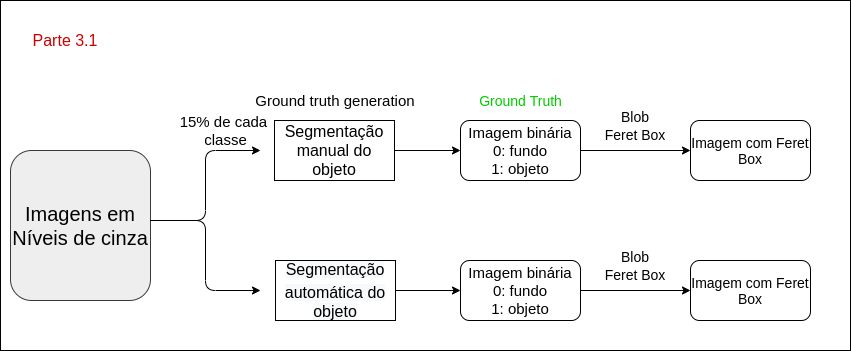

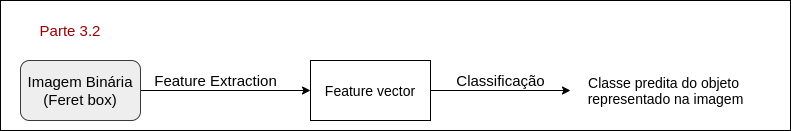

##2.1 - Ambiente de Trabalho

Este notebook foi desenvolvido no Google Colab. Assim, aproveitamos o fato de poder acessar o Google Drive diretamente. Contudo, para que isso seja possível é necessário ter acesso a pasta "Trabalho_Visão" (Link do Drive em 1), criar um atalho, desta pasta, no diretorio raiz do Drive ("/content/gdrive/My_Drive") e, por fim, executar o código abaixo para que o Colab tenha acesso ao seu Drive:

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


Após uma motagem do Drive ser bem sucedida, é necessário mudar o diretório de trabalho para a pasta "Trabalho_Visão". Isso é feito executando a celula abaixo:


In [2]:
import os
os.chdir('/content/gdrive/My Drive/Trabalho_Visao')

### Imports

In [3]:
from skimage.filters import gaussian
from skimage.filters import threshold_otsu

from skimage.morphology import binary_dilation
from skimage.morphology import square
from skimage.feature import canny
from skimage.feature import ORB
from skimage import io
from skimage.color import rgb2gray
from skimage.color import label2rgb
from skimage.util import invert
from skimage.util import numpy_pad
from skimage.measure import label
from skimage.measure import regionprops
from skimage.draw import rectangle
from skimage.draw import set_color

from sklearn.utils import shuffle
from sklearn.svm import SVC
from sklearn.model_selection import learning_curve
from sklearn.model_selection import train_test_split
from sklearn.model_selection import learning_curve
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import plot_confusion_matrix
from sklearn.preprocessing import StandardScaler


import numpy as np

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.patches as mpatches

from scipy import ndimage as ndi
from scipy.cluster.vq import *

import pandas as pd

import random

import pickle

### Carregar imagens na memória

Carrega as imagens GT, em tons de cinza, para reduzir o tempo de I/O

In [4]:
df = pd.read_csv('dataset/dataset.csv')

In [ ]:
pictures_dic = {}
unique_class = list(set(df['CLASS_NAME'].to_list()))
for classname in unique_class:
  file_list = os.listdir('Ground_Truth/%s/'%classname)
  for fname in file_list:
    fname = '/%s/'%classname + fname
    pathname = 'dataset/augmentation/originalGrayDataset' + fname
    pictures_dic[fname] = io.imread(pathname, as_gray=True)
print(pictures_dic.keys())

# 3 - Desenvolvimento

## 3.1 - Segmentação

### Segmentação Manual

A segmentação manual das imagens foi realizada utilizando o GIMP, e tem por objetivo criar uma certa quantidade de dados anotados. Com esses dados anotados, o algoritimos de ML será treinado para classificar os objetos da imagem. Também, com esses dados, que será feita a aferição da qualidade da segmentação automática e da localização da bouding box.

O número de dados anotados por classe é, o que representa 15,3% do total de dados:

- Caneta: 54;
- Livro: 33;
- PenDrive: 17;
- Caneca: 21;
- Perfume: 22;
- Calçado: 22;
- Mouse: 16;
- Controle: 22;
- Rolha: 21;
- Faca: 17;
- **Total**: 245

A seguir será apresentado algumas dessas anotações realizadas.

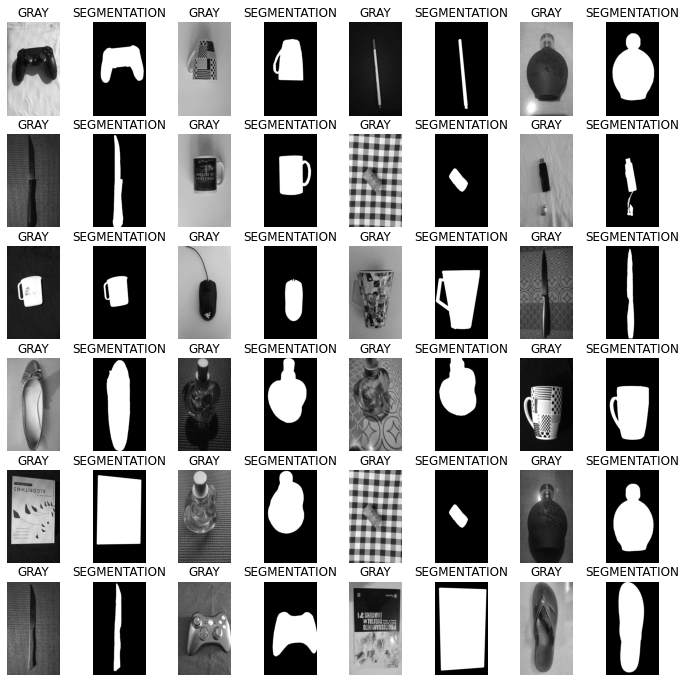

In [6]:
n_rows = 6
n_cols = 2 * 4
fig, axarr = plt.subplots(n_rows,n_cols, figsize=(12,12))

for i in range(n_rows):
  for j in range(0, n_cols, 2):
    picture_path = random.choice(list(pictures_dic.keys()))
    axarr[i, j].set_title('GRAY')
    axarr[i, j+1].set_title('SEGMENTATION')
    axarr[i, j].axis('off')
    axarr[i, j+1].axis('off')
    seg = io.imread('Ground_Truth' + picture_path, as_gray=True)
    axarr[i, j].imshow(pictures_dic[picture_path], cmap='gray')
    axarr[i, j+1].imshow(seg, cmap='gray')


### Segmentação Automática

A seguir são apresentados os métodos que se mostram mais satisfatórios para fazer a segmentação. O método que foi escolhido dentre eles é o método que utiliza o canny adaptativo (usando o threshold otsu).

Depois de alguns testes, foi optado pelo Canny. Utiliza o filtro canny para obter os contornos da imagem, como o canny
  possuem dois limiares, superior e inferior, eles foram escolhidos utilizando 
  o threshold otsu, depois a imagem é dilatada com o objetivo de fechar os contornos.
  Por fim, os contornos fechados são preenchidos.

In [7]:
## Simplesmente Binario
def random_binary():
  """
  Teste de sanidade, gera uma imagem binária aleatória para servir de padrão na avaliação dos outros métodos.
  """
  matrix = np.random.randint(2, size=(1280,720)).astype(bool)
  return matrix

In [8]:
def threshold_based(img):
  """
  Utiliza o filtro threshold_otsu para obter o threshold para filtrar a imagem.
  Verifica se um quadrado 10x10 do canto é predominantemente preto (valor = 0), caso contrário, inverte a imagem.

  Keyword arguments:
  img   --  array, representando imagem em tons de cinza shape(n, m)

  edge_based(array) -> array shape(n, m)
  """  
  # Filtro threshold_otsu
  thresh = threshold_otsu(img)
  binary = img > thresh
  
  # Para corrigir classificação incorreta, verifica se o canto é predominantemente preto.
  a = binary[0:10,0:10]
  score = np.sum(a == 0) / 100
  if score < 0.5:
    binary = invert(binary)
  
  return(binary)

In [9]:
def edge_based(img): 
  """
  Recebe uma imagem e faz a segmentação utilizando o Canny mais o OTSU

  Keyword arguments:
  img   --  array, representando imagem em tons de cinza shape(n, m)


  edge_based(array) -> array shape(n, m)
  """

  img = gaussian(img)
  ls = threshold_otsu(img)
  ls = 0.8 * ls
  li = 0.2 * ls

  edges = canny(img, sigma=1, low_threshold=li, high_threshold=ls)
  
  edges = binary_dilation(edges, square(5))
  fill = ndi.binary_fill_holes(edges)

  label_objects, nb_labels = ndi.label(fill)
  sizes = np.bincount(label_objects.ravel())
  mask_sizes = sizes > 20
  mask_sizes[0] = 0
  segmentacao = mask_sizes[label_objects]
  
  return segmentacao

### Apresentação Visual dos Resultados

A seguir é apresentado algums dos resultados alcançados utilizando a segmentação automática.

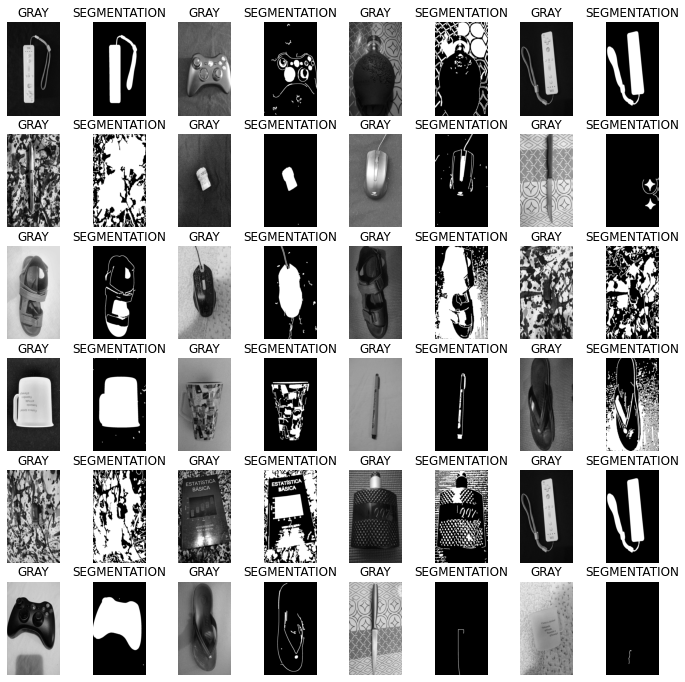

In [10]:
n_rows = 6
n_cols = 2 * 4
fig, axarr = plt.subplots(n_rows,n_cols, figsize=(12,12))

for i in range(n_rows):
  for j in range(0, n_cols, 2):
    
    picture_path = random.choice(list(pictures_dic.keys()))
    img = pictures_dic[picture_path]
    axarr[i, j].set_title('GRAY')
    axarr[i, j+1].set_title('SEGMENTATION')
    axarr[i, j].axis('off')
    axarr[i, j+1].axis('off')
    seg = edge_based(img)
    axarr[i, j].imshow(img, cmap='gray')
    axarr[i, j+1].imshow(seg, cmap='gray')

### Avaliação Segmentação Automática

Foram utilizados diversos algoritmo de segmentação automática, então, com o objetivo de encontrar o algoritmo que melhor é mais capaz de segmentar o objeto na imagem foi definido uma métrica, onde a imagem binária segmentada automaticamente foi comparada pixel a pixel com a imagem segmentada segmentada manualmente (ground truth) e desta forma, os algoritmos foram avaliados com base em sua média de porcentagem de acerto de cada imagem presente no ground truth.


In [11]:
score_vector = []
from skimage.metrics import adapted_rand_error
for image_path in pictures_dic.keys():
  # Load and Convert Ground_Truth
  y_true = io.imread('Ground_Truth' + image_path, as_gray=True)

  # Load image
  img = mpimg.imread('dataset/augmentation/originalGrayDataset' + image_path)
  y_pred = edge_based(img)
  y_pred = np.where(y_pred, 1, 0)

  error, precision, recall = adapted_rand_error(y_true.astype('uint8'), y_pred.astype('uint8'))
  
  # Get Score
  score_vector.append(2*recall*precision/(recall+precision))

In [12]:
print("Mean Score = %s"%np.mean(score_vector))
print("STD Score = %s"%np.std(score_vector))

Mean Score = 0.8545633458464869
STD Score = 0.11788200767599644


## 3.2 - Bounding Box

### Função para calcular a *Bounding Box*

Esta função procura na imagem todas as regiões existentes, mas seleciona apenas a com a maior área, sendo essa a mais provável de conter o objeto.
 
Código baseado em:
https://scikit-image.org/docs/dev/auto_examples/segmentation/plot_label.html

In [13]:
def find_box(image):
  """
  Recebe uma imagem localizando a maior caixa que pode ser inserida nos clusters de pixel da imagem.

  Keyword arguments:
  image   --  array, representando imagem binária (segmentação da imagem original)


  find_box(array) -> array, int, int 
  """

  # Limpar bordas da imagem
  image = numpy_pad(image, 1, 'constant', constant_values=0)

  # Procurar todas as caixas
  label_image = label(image)
  image_label_overlay = label2rgb(label_image, image=image, bg_label=0)
  
  # Escolher apenas a maior caixa encontrada
  if regionprops(label_image):
    max_area = 0
    for region in regionprops(label_image):
      if region.area >= max_area:
        minr, minc, maxr, maxc = region.bbox
        max_area = (maxc - minc) * (maxr - minr)
        regionMax = region
    
    # Desenhar na imagem
    coords = (minc, minr, maxc, maxr)
    h = maxc - minc
    w = maxr - minr

    rr, cc = rectangle( (minr, minc ), end = (maxr,maxc), shape=image_label_overlay.shape)
    rr[10:-10,10:-10] = 0
    set_color(image_label_overlay, (rr, cc), (255,0,0))

    return image_label_overlay, coords, h * w
  # Caso não encontre nenhuma caixa
  else:
    #print("Nenhuma caixa encontrada")
    #return image, None, 0
    return image, (0, 0, image.shape[0], image.shape[1]), 0

### Apresentar Resultado
A seguir, está apresentado, em ordem, a imagem filtrada e a *bounding box* em vermelho, no centro está o *ground truth* e a *bounding box* e na direita a imagem original.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, 'Original Image')

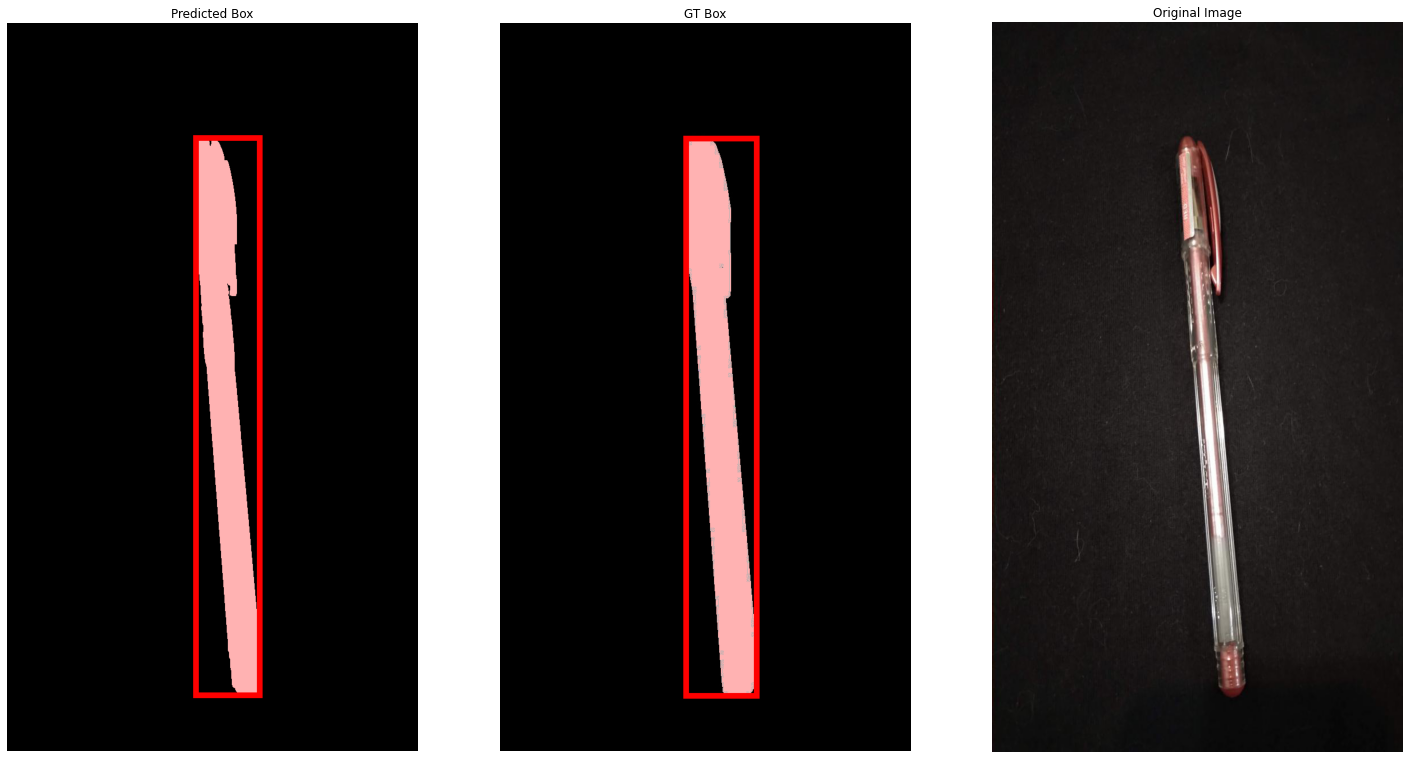

In [14]:
#random.seed(10)
image_path = random.choice(list(pictures_dic.keys()))
img_original = mpimg.imread('dataset' + image_path)

# Automatic
img = pictures_dic[image_path]
segmentation = edge_based(img)
img_box, bb_coords, area = find_box(segmentation)

# Manual
GT_img = io.imread('Ground_Truth' + image_path, as_gray=True)
GT_img_box, GT_center, GT_area = find_box(GT_img)

_,ax = plt.subplots(1,3, figsize=(25, 25))

ax[0].imshow(img_box)
ax[0].axis('off')
ax[0].set_title('Predicted Box')

ax[1].imshow(GT_img_box)
ax[1].axis('off')
ax[1].set_title('GT Box')

ax[2].imshow(img_original)
ax[2].axis('off')
ax[2].set_title('Original Image')


### Medir o erro da caixa encontrada

Medir o erro da caixa encontrada para avaliar a habilidade de cada método de detectar o objeto, a seguinte função estima a *bounding box* e compara com a obtida no *ground truth*, resultando em dois parâmetros, área (em % da área esperada) e distância do centro (em pixel).
 
O erro da área é apresentado como a porcentagem de erro e é calculado pela diferença entre a área da caixa do algoritmo aleatório e a área do ground truth e então dividindo a área do ground truth. Portanto 0% seria o valor ideal.
 
O erro do centro é calculado como a distância euclidiana do centro da caixa no algoritmo aleatório e da caixa do ground truth. Novamente, o valor ideal seria 0 pixels.


In [15]:
erro_area = []
erro_centro = []
cnt_not_found = 0
for image_path in pictures_dic.keys():
    
  # Automatic
  img = pictures_dic[image_path]
  img = edge_based(img)
  _, center, area = find_box(img)

  # Manual
  img2 = io.imread('Ground_Truth' + image_path, as_gray=True)
  _, center2, area2 = find_box(img2)

  if not center == None and not center2 == None and not area == 0 and not area2 == 0:
    erro_centro.append(np.sqrt( (center[0] - center2[0])^2 + (center[1] - center2[1])^2 ))
    erro_area = abs(int(area - area2) / area)
  else:
    cnt_not_found += 1

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in sqrt
  app.launch_new_instance()


In [17]:
erro_centro = np.where(np.isfinite(erro_centro), erro_centro, 0)
print('Erro no Centro da Caixa\n Mean = %.2f Var = %.2f' % (np.mean(erro_centro), np.std(erro_centro)))
erro_area = np.where(np.isfinite(erro_area), erro_area, 0)
print('Erro na Area da Caixa\n Mean = %.2f Var = %.2f' % (np.mean(erro_area), np.std(erro_area)))
print('Erro caixas não encontradas = %d' % (cnt_not_found))

Erro no Centro da Caixa
 Mean = 7.17 Var = 7.86
Erro na Area da Caixa
 Mean = 0.01 Var = 0.00
Erro caixas não encontradas = 3


Como foi obtido uma distância média entre o centro da caixa obtido através da segmentação manual e o centro obtido através da segmentação automática de 7 pixels (considerando que são 1460 pixels entre o canto inferior e o canto superior) e que a discrepância da área da caixa, em relação a área da caixa obtida da segmentação manual foi de 15%, podemos concluir que a segmentação automática encontra a bounding box de forma satisfatória.

## 3.3 - Extração de características

A extração de característica é a parte fundamental para uma correta classificação. Dessa forma, foi experimentado diversos algorítimos, entre eles, o Haar-like feature, o Hu Moments, o histograma de gradients. Esses testes podem ser encontrados no EP_03_testes.ipynb e testes.ipynb na pasta Notebook_testes no Drive. Assim, ao final optamos por utilizar o método que utiliza o ORB (Oriented Fast and Rotated BRIEF) com o k-means clustering, a ideia teve como inspiração o artigo [1] e a implementação baseada e adaptada no código encontrado no git: https://github.com/meghasoni1/Object-Classification-using-SVM-Classifier/blob/master/getFeatures.py. 

Tanto a implementação quanto o artigo trazem como algoritimo para a extração dos descritores o SIFIT, contudo, optamos por utilizar o ORB. A sequência da extração de caracteristica fica da forma:

 - Segmentação automática;
 - Encontrar a box tanto da segmentação encontrada, quanto da inversa dessa segmentação;
 - Detecção e extração com ORB nas box's encontradas;
 - K-mean clustering;
 - Histograma das características;
 - Vetorização com Tf-Idf





In [18]:
def extract_features(df_imgs, root_path='./dataset/augmentation/', training=True,
                     datasets=[
                               'originalGrayDataset/', 
                               'augmentedDataset/mean/',
                               'augmentedDataset/log/',
                               'augmentedDataset/gradient/',
                               'augmentedDataset/exp/'
                               ],
                     cluster = None,
                     n_datasets = 5
                      ):
  labels = []
  fea_det = ORB()
  des_list = []
  qntd = 0
  for dataset in datasets[:n_datasets]:
    for _, image_row in df_imgs.iterrows():
        img = io.imread(root_path + dataset + image_row.DIR, as_gray=True)
        seg = edge_based(img)
        
        _, bb_coords, area = find_box(seg)
        minc, minr, maxc, maxr = bb_coords
        img_original = img[minr:maxr,minc:maxc]
        _, bb_coords, area = find_box(invert(seg))
        minc, minr, maxc, maxr = bb_coords
        img_inversa = img[minr:maxr,minc:maxc]
        
        try:
          fea_det.detect_and_extract(img_original)
          ori = fea_det.descriptors.astype('float32')

          fea_det.detect_and_extract(img_inversa)
          inv = fea_det.descriptors.astype('float32')

        except RuntimeError:
          continue
        
        des_list.append((image_row.DIR, np.vstack((ori, inv))))   
        labels.append(image_row.CLASS_NAME)
        qntd += 1

    print(qntd)

  # Stack all the descriptors vertically in a numpy array
  descriptors = des_list[0][1]
  for _, descriptor in des_list[1:]:
      descriptors = np.vstack((descriptors, descriptor))  

  # Perform k-means clustering
  k = 1620
  if training:
    voc, variance = kmeans(descriptors, k, 1) 
  else:
    voc, variance = cluster
  # Calculate the histogram of features
  im_features = np.zeros((qntd, k), "float32")
  for i in range(qntd):
      words, distance = vq(des_list[i][1],voc)
      for w in words:
          im_features[i][w] += 1

  # Perform Tf-Idf vectorization
  nbr_occurences = np.sum( (im_features > 0) * 1, axis = 0)
  idf = np.array(np.log((1.0*qntd+1) / (1.0*nbr_occurences + 1)), 'float32')
 
  cluster = (voc, variance)
  return im_features, labels, cluster

In [19]:
df_imgs = df.sample(1620, random_state=20)
imgs_train, imgs_test =  (df_imgs[:1400], df_imgs[1400:])  

In [ ]:
X, y, cluster = extract_features(imgs_train, n_datasets=1)
pickle.dump(X, open("Features/features_ORB_train.p", "wb"))  
pickle.dump(y, open("Features/labels_ORB_train.p", "wb")) 

In [ ]:
X_test, y_test, _ = extract_features(imgs_test, cluster=cluster, n_datasets=1, training=False)
pickle.dump(X_test, open("Features/features_ORB_test.p", "wb"))  
pickle.dump(y_test, open("Features/labels_ORB_test.p", "wb"))  

Carregar as features e as respectivas labels.

In [20]:
X = pickle.load(open("Features/features_ORB_train.p", "rb"))  
y = pickle.load(open("Features/labels_ORB_train.p", "rb"))  
X_test = pickle.load(open("Features/features_ORB_test.p", "rb"))
y_test = pickle.load(open("Features/labels_ORB_test.p", "rb")) 

##  3.4 - Classificação

Como foi proposto, pelo professor, a utilização de uma SVM para realizar a classificação dos objetos optamos por utilizar a implementação em sklearn da mesma, e ajustamos os parâmetros durante o treino e validação dos dados. Dessa forma, ficou preservado as imagens de testes, que só foi executada após todos os ajustes da SVM.

In [21]:
# normalizar os dados
sc = StandardScaler()
X = sc.fit_transform(X)
X_test = sc.transform(X_test)

In [22]:
# separacao em treinamento e validacao
X_train, X_val, y_train, y_val = train_test_split(
                                                      X, y, test_size=0.3
                                                    )
X_train.shape

(937, 1620)

In [23]:
svm = SVC(kernel='sigmoid', degree=3, gamma='auto', class_weight='balanced', C=1, coef0=0).fit(X_train, y_train)

Não foi utilizado todo dataset pois o extrator de característica escolhido necessita de mais memória do que nós temos a disposição. No caso utilizamos o Colab e ele disponibiliza aproximadamente 12GB.

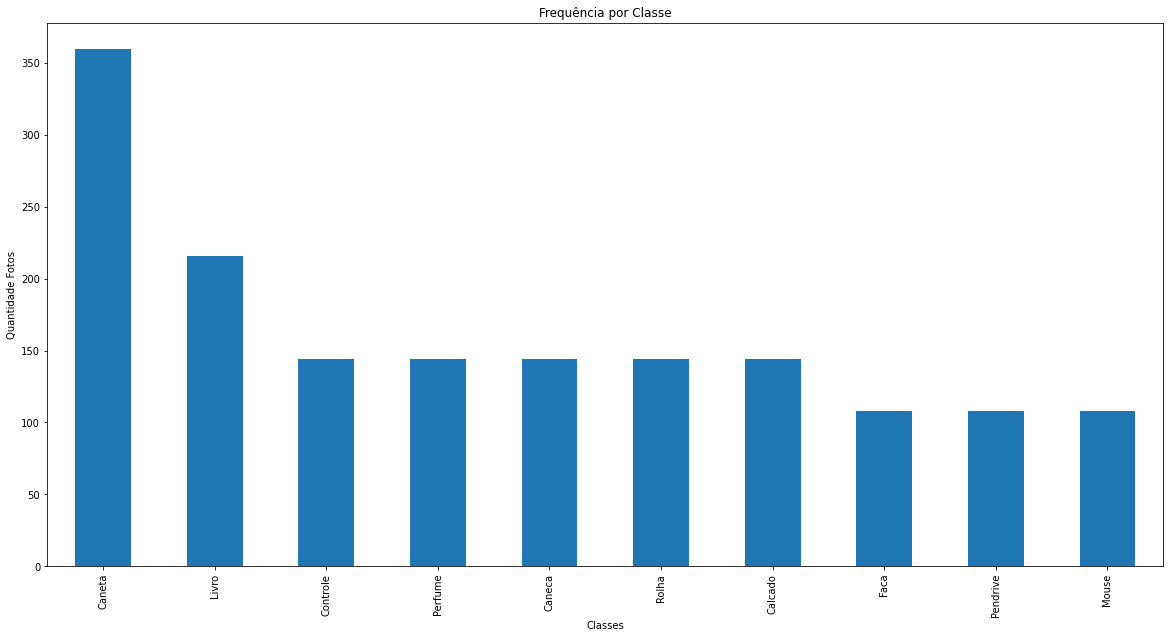

In [24]:
fig, axs1 = plt.subplots(1, 1, figsize=(20, 10))
axs1.set(ylabel='Quantidade Fotos', xlabel='Classes', title='Frequência por Classe')
pl = df_imgs['CLASS_NAME'].value_counts().plot(ax=axs1, kind='bar')

# 4 - Resultados

In [25]:
# retirado do tutorial do sklearn de plot learning curve com algumas alterações
# https://scikit-learn.org/stable/auto_examples/model_selection/plot_learning_curve.html

def plot_learning_curve(estimator, title, X, y, axes=None, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate 3 plots: the test and training learning curve, the training
    samples vs fit times curve, the fit times vs score curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    axes : array of 3 axes, optional (default=None)
        Axes to use for plotting the curves.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : int, cross-validation generator or an iterable, optional
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:

          - None, to use the default 5-fold cross-validation,
          - integer, to specify the number of folds.
          - :term:`CV splitter`,
          - An iterable yielding (train, test) splits as arrays of indices.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : int or None, optional (default=None)
        Number of jobs to run in parallel.
        ``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.
        ``-1`` means using all processors. See :term:`Glossary <n_jobs>`
        for more details.

    train_sizes : array-like, shape (n_ticks,), dtype float or int
        Relative or absolute numbers of training examples that will be used to
        generate the learning curve. If the dtype is float, it is regarded as a
        fraction of the maximum size of the training set (that is determined
        by the selected validation method), i.e. it has to be within (0, 1].
        Otherwise it is interpreted as absolute sizes of the training sets.
        Note that for classification the number of samples usually have to
        be big enough to contain at least one sample from each class.
        (default: np.linspace(0.1, 1.0, 5))
    """
    if axes is None:
        _, axes = plt.subplots(1, 3, figsize=(20, 7))

    axes[0].set_title(title)
    if ylim is not None:
        axes[0].set_ylim(*ylim)
    axes[0].set_xlabel("Training examples")
    axes[0].set_ylabel("Score")

    train_sizes, train_scores, test_scores, fit_times, _ = \
        learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs,
                       train_sizes=train_sizes,
                       return_times=True)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)

    # Plot learning curve
    axes[0].grid()
    axes[0].fill_between(train_sizes, train_scores_mean - train_scores_std,
                         train_scores_mean + train_scores_std, alpha=0.1,
                         color="r")
    axes[0].fill_between(train_sizes, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1,
                         color="g")
    axes[0].plot(train_sizes, train_scores_mean, 'o-', color="r",
                 label="Training score")
    axes[0].plot(train_sizes, test_scores_mean, 'o-', color="g",
                 label="Cross-validation score")
    axes[0].legend(loc="best")

    # Plot n_samples vs fit_times
    axes[1].grid()
    axes[1].plot(train_sizes, fit_times_mean, 'o-')
    axes[1].fill_between(train_sizes, fit_times_mean - fit_times_std,
                         fit_times_mean + fit_times_std, alpha=0.1)
    axes[1].set_xlabel("Training examples")
    axes[1].set_ylabel("fit_times")
    axes[1].set_title("Scalability of the model")

    # Plot fit_time vs score
    axes[2].grid()
    axes[2].plot(fit_times_mean, test_scores_mean, 'o-')
    axes[2].fill_between(fit_times_mean, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1)
    axes[2].set_xlabel("fit_times")
    axes[2].set_ylabel("Score")
    axes[2].set_title("Performance of the model")

    return plt

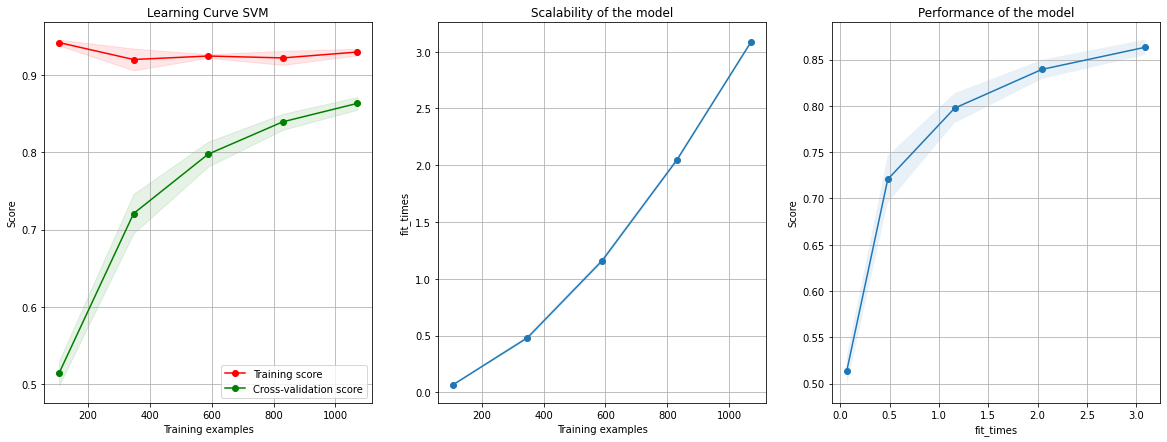

In [26]:
pltt = plot_learning_curve(svm, 'Learning Curve SVM', X, y, n_jobs=-1)
pltt.show()

Analisando o primeiro gráfico acima, é possível notar que o modelo não ocorreu overfit durante o treinamento, podendo indicar que o modelo e os parâmetros foram ajustados corretamente. É possível observar também que o modelo pode melhorar um pouco mais ao adicionar mais dados para treinamento.

In [27]:
svm_pred = svm.predict(X_val)
svm_accuracy = accuracy_score(y_val, svm_pred)
svm_f1 = f1_score(y_val, svm_pred, average='weighted')
print('Accuracy (Sigmoid Kernel): ', "%.2f" % (svm_accuracy*100))
print('F1 (Sigmoid Kernel): ', "%.2f" % (svm_f1*100))

Accuracy (Sigmoid Kernel):  84.83
F1 (Sigmoid Kernel):  85.71


As imagens usados para teste não influenciaram no ajuste dos parâmetros do modelo. Elas foram separadas antes da extração de caractrística. E o resultado alcançado mostra que o modelo consegue classifar bem as diferentes classes.

In [30]:
svm_pred = svm.predict(X_test)
svm_accuracy = accuracy_score(y_test, svm_pred)
svm_f1 = f1_score(y_test, svm_pred, average='weighted')
print('Accuracy (Sigmoid Kernel): ', "%.2f" % (svm_accuracy*100))
print('F1 (Sigmoid Kernel): ', "%.2f" % (svm_f1*100))

Accuracy (Sigmoid Kernel):  87.56
F1 (Sigmoid Kernel):  87.99


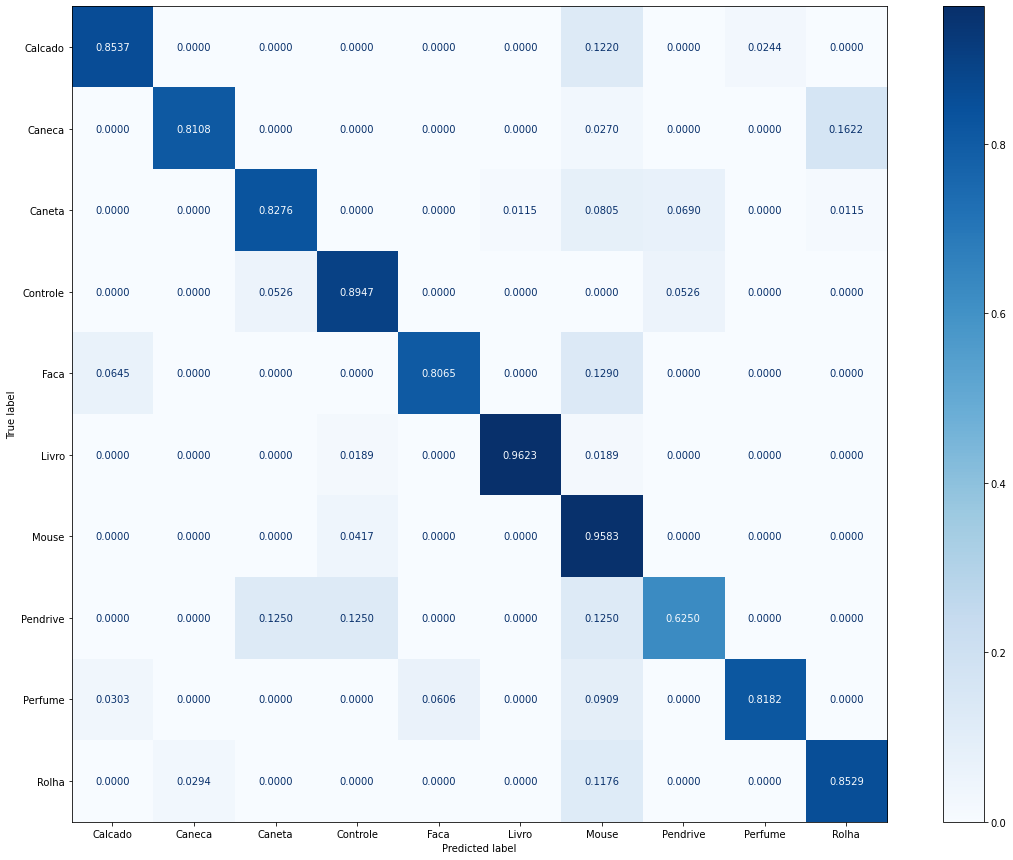

In [28]:
title = "Confusion matrix"
class_names = imgs_train['CLASS_NAME'].unique()
_, axes = plt.subplots(1, 1, figsize=(20, 15))
disp = plot_confusion_matrix(svm, X_val, y_val,
                            cmap=plt.cm.Blues,
                            normalize='true',
                            values_format='.4f',
                            ax=axes)
plt.show()

A matriz de confusão acima traz alguns resultados esperados, como a acurácia com a classe livro, mas também traz algumas surpresas, como confundir muito dos objetos como um mouse.


In [33]:
! pip freeze > requeriments.txt

# Referências

[1] DESELAERS, Thomas; HEIGOLD, Georg; NEY, Hermann. Object classification by fusing SVMs and Gaussian mixtures. **Pattern Recognition**, v. 43, n. 7, p. 2476-2484, 2010.
